# Advanced Lane Finding 

[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

First of all, I'd like to share results of my work as I've spend pretty much time on tuning my algorithm.
I've uploaded the processed video to the youtube, so you can check:

1. [Project video](https://www.youtube.com/watch?v=cONUt8byoMM)
2. [Challenge video](https://www.youtube.com/watch?v=OmsU5a7kjAU)
3. [Harder challenge video](https://www.youtube.com/watch?v=fKTY-G3n_pA)

Now lets go through the steps how I achieved this.

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

First of all, I define global variables `SHAPE`, `G_W` and `G_H` (which will be used all over the code) and save image dimensions into them. 

In [50]:
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#
# Define global constants corresponding to image dimensions
#
img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

G_SHAPE = img.shape
G_W = G_SHAPE[1]
G_H = G_SHAPE[0]

def plot_two_pictures(pic1, title1, pic2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(pic1, cmap='gray')
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(pic2, cmap='gray')
    ax2.set_title(title2, fontsize=30)

Chessboard corners are found the same way as described in study materials, using `cv2.findChessBoardCorners` function. The only one difference is the size of the chessboard, which is 6x9, not 6x8 like in examples. Then I call `cv2.calibarateCamera`to obtain camera matrix and distortion coefficients (`G_MTX` and `G_DIST`).

In [51]:
#
# Find coners on chessboard images and prepare points for calibrateCamera
#
CB_X = 6
CB_Y = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((CB_X * CB_Y, 3), np.float32)
objp[:,:2] = np.mgrid[0 : CB_Y, 0 : CB_X].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    chess_img = cv2.imread(fname)
    chess_img_gray = cv2.cvtColor(chess_img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(chess_img_gray, (CB_Y, CB_X), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

#
# Find camera calibration parameters given object points and image points
#
ret, G_MTX, G_DIST, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

## 2. Apply a distortion correction to raw images.

For convenicence I define `undistort` function, which will be applied to all images in this notebook as a first processing step. You can see what result it produces on exmaple.


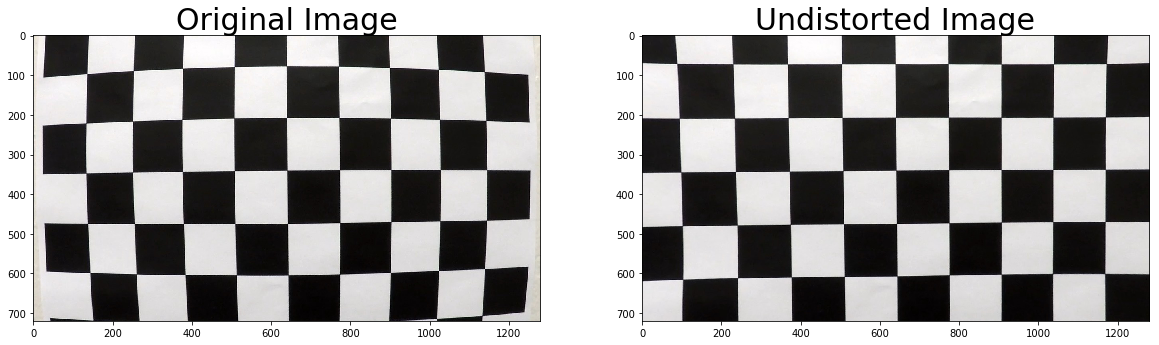

In [52]:
#
# Helper function to undistort images
#
def undistort(img):
    dst = cv2.undistort(img, G_MTX, G_DIST, None, G_MTX)
    return dst

dst = undistort(img)

# Visualize undistortion
plot_two_pictures(img, 'Original Image', dst, 'Undistorted Image')

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

To create a thresholded binary image I define some helper functions:

* `channel_select` to select one channel of the image, for example R in RGB format, or S in HLS
* `grayscale` to convert image to gray
* `sobel_thresh` to apply sobel filter over 'x' axis and then threshold the result

In [53]:
def channel_select(channel, thresh=(0, 255)):
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def sobel_thresh(channel, thresh=(30, 255)):
    sobel = cv2.Sobel(channel, cv2.CV_64F, 1, 0)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

During work on this project I found a useful method for normalization of the image - [Contrast Limited Adaptive Histogram Equalization](https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html). Here I define function, which applies it.

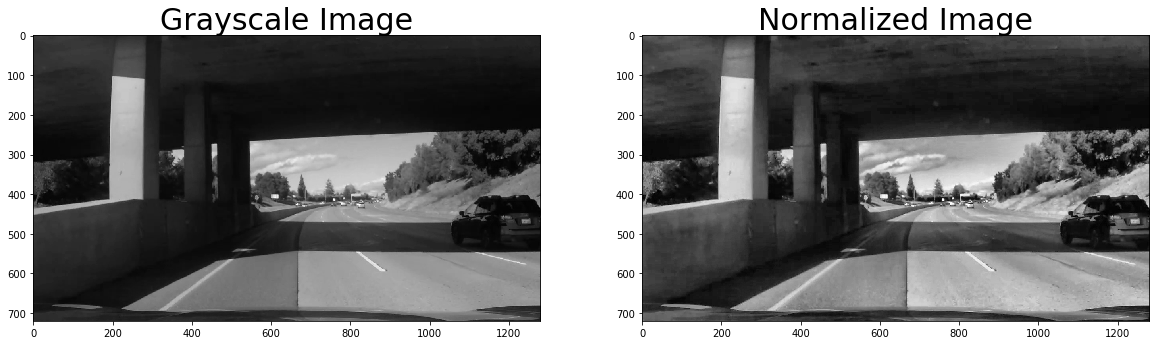

In [54]:
G_CLACHE = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
def clache(channel):
    return G_CLACHE.apply(channel)

img = mpimg.imread('dbg/vid1_dbg_125.jpg') 
und = undistort(img)
gray = grayscale(img)
norm = clache(gray)

plot_two_pictures(gray, 'Grayscale Image', norm, 'Normalized Image')

Do determine [lightness](https://robots.thoughtbot.com/closer-look-color-lightness) of color I utilized W3C Method:

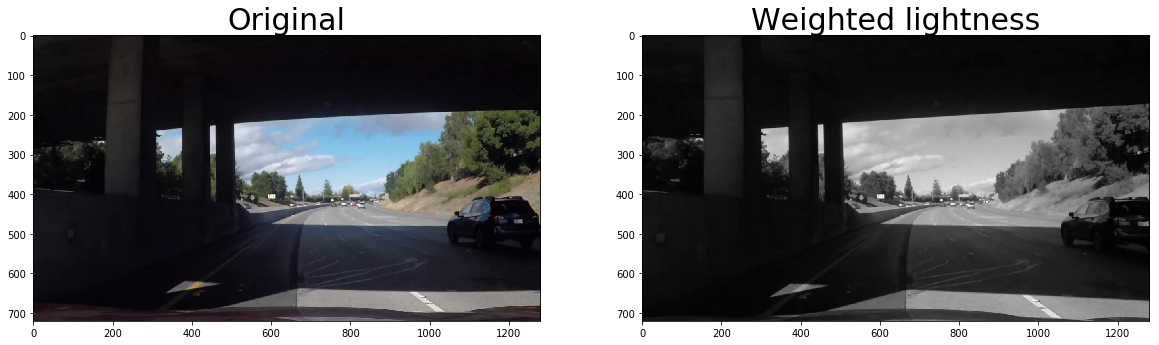

In [55]:
img = mpimg.imread('dbg/vid1_dbg_131.jpg')
und = undistort(img)

def lightness(img):
    return np.uint8(img[:,:,0] * 0.299 + img[:,:,1] * 0.587 + img[:,:,2] * 0.1170)

wl = lightness(und)

plot_two_pictures(img, 'Original', wl, 'Weighted lightness')


To get acceptable binary images on all three test videos, I created a pretty complex pipeline.
To make it more clear, I split it into several filters:

* Sobel filter over S channel
* Combination of sobel filters with different thresholds
* Yellow filter
* White filter
* Sobel filter over lightness

Let's see how I came to it.
At first, I utilzed S-channel thresholding and sobel thresholding for gray image.

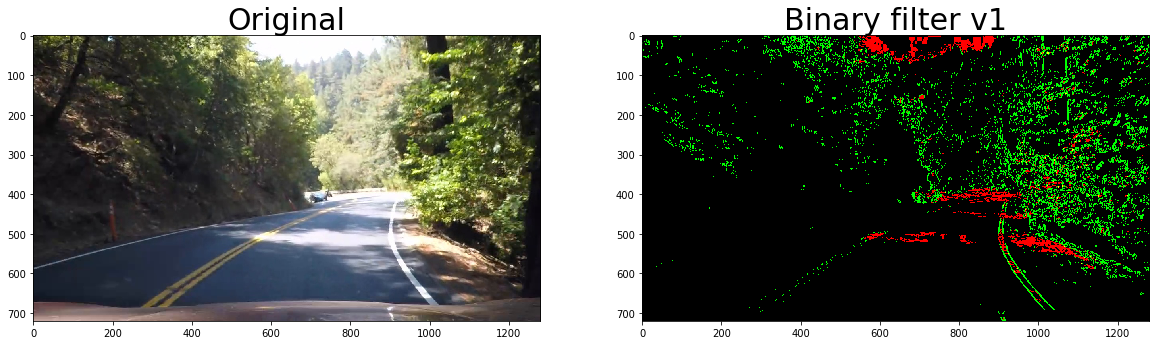

In [56]:
def make_binary_v1(img):
    img = np.copy(img)

    # get separate channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = grayscale(img)
    S_channel = hls[:,:,2]
    
    S_filter = channel_select(S_channel, (220, 255))
    Sobel_filter = sobel_thresh(gray, (30, 255))
    
    zeros = np.zeros_like(gray)
    color_binary = np.dstack((S_filter, Sobel_filter, zeros)) * 255
    
    combined_binary = np.zeros_like(gray)
    combined_binary[(S_filter == 1) | (Sobel_filter == 1)] = 1
    return (combined_binary, color_binary)

img = mpimg.imread('dbg/vid2_dbg_344.jpg')
bin, col = make_binary_v1(undistort(img))
plot_two_pictures(img, 'Original', col, 'Binary filter v1')

As you can see, filtering of S-channel, gives to big regions on some images, so I replaced it with sobel filter over S-channel. To improve detection of edges in different light conditions I applied CLACHE normalization to the gray channel.

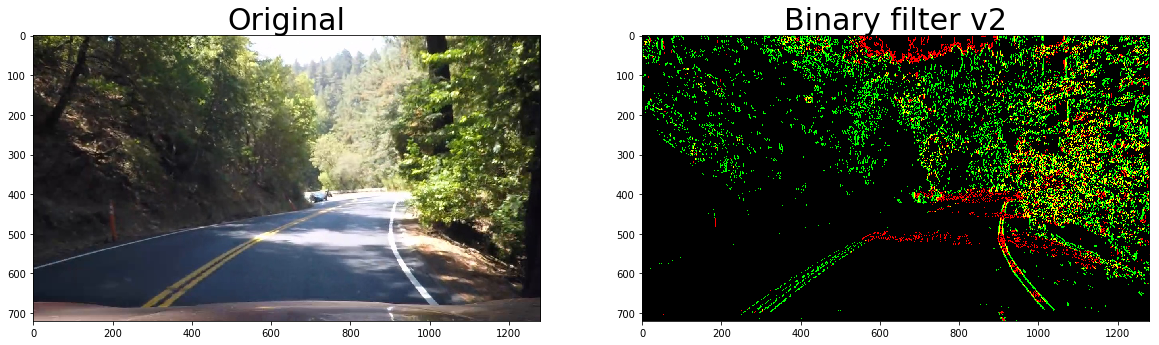

In [57]:
def make_binary_v2(img):
    img = np.copy(img)

    # get separate channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray_cl = clache(grayscale(img))
    S_channel = hls[:,:,2]
    
    S_filter = sobel_thresh(S_channel,(30, 255))
    Sobel_filter = sobel_thresh(gray_cl, (30, 255))
    
    zeros = np.zeros_like(gray)
    color_binary = np.dstack((S_filter, Sobel_filter, zeros)) * 255
    
    combined_binary = np.zeros_like(gray)
    combined_binary[(S_filter == 1) | (Sobel_filter == 1)] = 1
    return (combined_binary, color_binary)

img = mpimg.imread('dbg/vid2_dbg_344.jpg')
bin, col = make_binary_v2(undistort(img))
plot_two_pictures(img, 'Original', col, 'Binary filter v2')

To further improve result on this ficture, I wanted to remove red pixels in the midle (edge of sunlight and shadow on road and roadside). To do this I made two masks:

* Gray and whtie mask (`gray_reg_er` in code) a mask which selects gray regions (differece between R, G and B componets should be less that 25) and erodes it a little using `cv2.erode`.
* Color mask (`color_reg` in code) - a mask, which selects colored regions (difference between R, G and B more than 15)

I apply these masks to `S filter` and get better result.

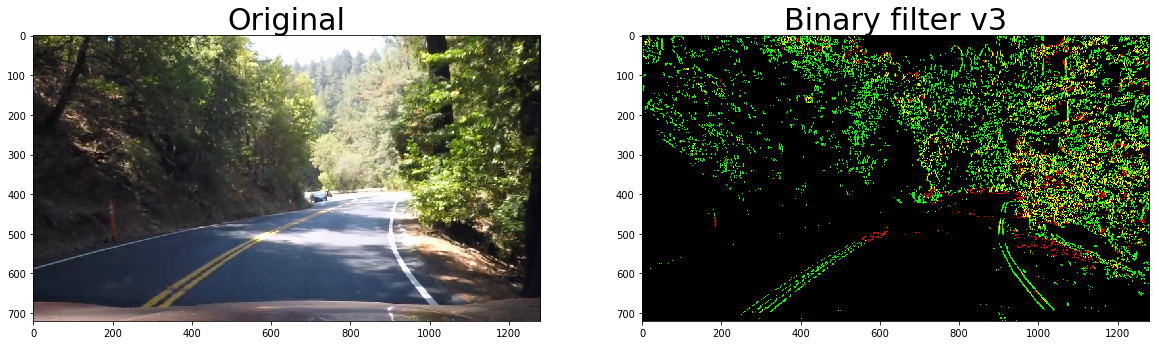

In [58]:
def make_binary_v3(img):
    img = np.copy(img)

    # get separate channels
    R_channel = img[:,:,0]
    G_channel = img[:,:,1]
    B_channel = img[:,:,2]
    diff_RG = abs(np.int32(R_channel) - np.int32(G_channel))
    diff_GB = abs(np.int32(G_channel) - np.int32(B_channel))
    diff_RB = abs(np.int32(R_channel) - np.int32(B_channel))
    gray = grayscale(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S_channel = hls[:,:,2]
    gray_cl = G_CLACHE.apply(gray)
    R_channel_cl = G_CLACHE.apply(img[:,:,0])
    G_channel_cl = G_CLACHE.apply(img[:,:,1])
    B_channel_cl = G_CLACHE.apply(img[:,:,2])

    # Gray mask
    gray_reg = np.zeros_like(gray)
    gray_reg[(diff_RG <= 25) & (diff_GB <= 25) & (diff_RB <= 25)] = 1
    gray_reg_er = cv2.erode(gray_reg, np.ones((5,5)), iterations = 2)
    
    # Color mask
    color_reg = np.zeros_like(gray)
    color_reg[(diff_RG > 15) & (diff_GB > 15) & (diff_RB > 15)] = 1
    color_reg_er = cv2.erode(color_reg, np.ones((5,5)), iterations = 2)
    
    S_filter = sobel_thresh(S_channel,(30, 255))
    S_filter[(color_reg_er == 1)] = 0
    S_filter[(gray_reg_er == 1)] = 0
    
    Sobel_filter = sobel_thresh(gray_cl, (30, 255))
    
    zeros = np.zeros_like(gray)
    color_binary = np.dstack((S_filter, Sobel_filter, zeros)) * 255
    
    combined_binary = np.zeros_like(gray)
    combined_binary[(S_filter == 1) | (Sobel_filter == 1)] = 1
    return (combined_binary, color_binary)

img = mpimg.imread('dbg/vid2_dbg_344.jpg')
bin, col = make_binary_v3(undistort(img))
plot_two_pictures(img, 'Original', col, 'Binary filter v3')

Next thing was to tackle very dark regions (like under the bridge in challenge video). To do this I added low-thresholded sobel filter masked it with grey mask with subtracted light pixels (not to delete white lines). In the code this mask is named `gray_nowhite_reg`.

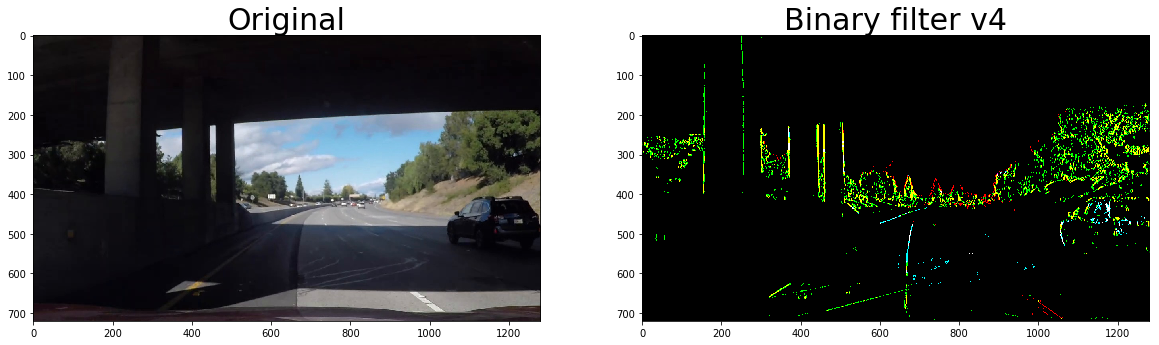

In [75]:
def make_binary_v4(img):
    img = np.copy(img)

    # get separate channels
    R_channel = img[:,:,0]
    G_channel = img[:,:,1]
    B_channel = img[:,:,2]
    diff_RG_abs = abs(np.int32(R_channel) - np.int32(G_channel))
    diff_BG = (np.int32(B_channel) - np.int32(G_channel))
    diff_BR = (np.int32(B_channel) - np.int32(R_channel))
    diff_GB_abs = abs(diff_BG)
    diff_RB_abs = abs(diff_BR)
    gray = grayscale(img)
    wl = np.uint8(R_channel*0.299 + G_channel*0.587 + B_channel*0.1170)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S_channel = hls[:,:,2]
    gray_cl = G_CLACHE.apply(gray)
    R_channel_cl = G_CLACHE.apply(img[:,:,0])
    G_channel_cl = G_CLACHE.apply(img[:,:,1])
    B_channel_cl = G_CLACHE.apply(img[:,:,2])
    
    #
    # S filter
    #
    # Gray mask
    gray_reg = np.zeros_like(gray)
    gray_reg[(diff_RG_abs <= 25) & (diff_GB_abs <= 25) & (diff_RB_abs <= 25)] = 1
    gray_reg_er = cv2.erode(gray_reg, np.ones((5,5)), iterations = 2)
    # Color mask
    color_reg = np.zeros_like(gray)
    color_reg[(diff_RG_abs > 15) & (diff_GB_abs > 15) & (diff_RB_abs > 15)] = 1
    color_reg_er = cv2.erode(color_reg, np.ones((5,5)), iterations = 2)
    # Filter
    S_filter = sobel_thresh(S_channel,(30, 255))
    S_filter[(color_reg_er == 1)] = 0
    S_filter[(gray_reg_er == 1)] = 0
    
    #
    # Sobel filters
    #
    # Dark blue mask
    dark_blue_reg = np.zeros_like(gray)
    dark_blue_reg[(diff_BG > 10) & (diff_BR > 10)] = 1
    dark_blue_reg[(gray_cl >= 90)] = 0
    dark_blue_reg_dl = cv2.dilate(dark_blue_reg, np.ones((5,5)), iterations = 1)
    # Common filter
    sobel_x = sobel_thresh(gray_cl, (30, 255))
    # Shadow filter
    sobel_x_low = sobel_thresh(gray_cl, (15, 255))
    shadow_mask = channel_select(wl, (0, 100))
    shadow_mask_dl = cv2.dilate(shadow_mask, np.ones((5,5)), iterations = 1)
    sobel_shadows = sobel_x_low & shadow_mask_dl
    # Dark blue filter
    sobel_dark_blue = dark_blue_reg_dl & sobel_x_low
    
    Sobel_filter = sobel_x | sobel_shadows # sobel_dark_blue

    #
    # Output
    #
    zeros = np.zeros_like(gray)
    color_binary = np.dstack((sobel_x, sobel_shadows, sobel_dark_blue)) * 255
    combined_binary = np.zeros_like(gray)
    combined_binary[(S_filter == 1) | (Sobel_filter == 1)] = 1
    return (combined_binary, color_binary)

img = mpimg.imread('dbg/vid1_dbg_131.jpg')
bin, col = make_binary_v4(undistort(img))
plot_two_pictures(img, 'Original', col, 'Binary filter v4')

#### 2. Combination of sobel filters with different thresholds

At first, I started common sobel thresholding in 'x' direction. I faced a problem that it can not find edges in shadows.
So I found a tricky way to find them.

I used sobel with lower threshold, but applieded it only to shadowed areas. 
* 
* Low-thresholded sobel filter masked by dark regions of the image
* Low-thresholded sobel filter masked by dark blue regions of the image

In [76]:
fname = 'test_images/straight_lines2.jpg'
img = mpimg.imread(fname) 
undist = undistort(img)

# Edit this function to create your own pipeline.
def make_binary(img):
    img = np.copy(img)
    
    #denoised = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7,21)

    # 
    # Prepare masks
    #
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = grayscale(img)
    R_channel = img[:,:,0]
    G_channel = img[:,:,1]
    B_channel = img[:,:,2]
    
    #H_channel = hls[:,:,0]
    #L_channel = hls[:,:,1]
    S_channel = hls[:,:,2]
    
    wl = np.uint8(R_channel*0.299 + G_channel*0.587 + B_channel*0.1170)
    
    gray_cl = G_CLACHE.apply(gray)
    R_channel_cl = G_CLACHE.apply(img[:,:,0])
    G_channel_cl = G_CLACHE.apply(img[:,:,1])
    B_channel_cl = G_CLACHE.apply(img[:,:,2])

    # Gray mask
    gray_reg = np.zeros_like(gray)
    diff_RG = abs(np.int32(R_channel) - np.int32(G_channel))
    diff_GB = abs(np.int32(G_channel) - np.int32(B_channel))
    diff_RB = abs(np.int32(R_channel) - np.int32(B_channel))
    gray_reg[(diff_RG <= 25) & (diff_GB <= 25) & (diff_RB <= 25)] = 1
    gray_reg_er = cv2.erode(gray_reg, np.ones((5,5)), iterations = 2)
    
    # Gray mask + white lanes
    white_mask = channel_select(gray, (180, 255))
    white_mask = cv2.dilate(white_mask, np.ones((5,5)), iterations = 1)
    gray_and_white_reg = np.copy(gray_reg)
    gray_and_white_reg[(white_mask == 1)] = 0
    
    # Colored mask
    color_reg = np.zeros_like(gray)
    color_reg[(diff_RG > 15) & (diff_GB > 15) & (diff_RB > 15)] = 1
    color_reg_er = cv2.erode(color_reg, np.ones((5,5)), iterations = 2)
     
    # Dark blue mask
    dark_blue_reg = np.zeros_like(gray)
    diff1 = (np.int32(B_channel) - np.int32(G_channel))
    diff2 = (np.int32(B_channel) - np.int32(R_channel))
    dark_blue_reg[(diff1 > 10) & (diff2 > 10)] = 1
    dark_blue_reg[(gray_cl >= 90)] = 0
    dark_blue_reg_dl = cv2.dilate(dark_blue_reg, np.ones((5,5)), iterations = 1)
    dark_blue_reg_er = cv2.erode(dark_blue_reg, np.ones((5,5)), iterations = 2)
    
    #
    # Do thresholding
    #
    
    # 1. Threshold HLS
    S_sobel = sobel_thresh(S_channel,(30, 255))
    HLS_binary = S_sobel
    #HLS_binary[(color_reg_er == 1)] = 0
    HLS_binary[(gray_reg_er == 1)] = 0
    
    
    # 2. Threshold based on sobel edge detection
    sobel_x = sobel_thresh(gray_cl, (30, 255))
    sobel_x[(gray_and_white_reg == 1)] = 0
    
    sobel_strong = sobel_thresh(gray_cl, (15, 255))
    wl_mask = channel_select(wl, (100, 255))
    wl_mask_dl = cv2.dilate(wl_mask, np.ones((5,5)), iterations = 1)
    high_S = channel_select(S_channel, (40, 255))
    high_S_dl = cv2.dilate(high_S, np.ones((5,5)), iterations = 1)
    sobel_dark = np.copy(sobel_strong)
    sobel_dark[wl_mask_dl == 1] = 0
    #sobel_dark[high_S_dl == 0] = 0
    
    sobel_dark_blue = np.copy(dark_blue_reg_dl)
    sobel_dark_blue[(sobel_strong == 0)] = 0
    sobel_dark_blue[(high_S_dl == 0)] = 0
       
    sobel = sobel_x | sobel_dark | sobel_dark_blue    
            
    # 3. Color threshold
    RGB_binary = np.zeros_like(gray_cl)
    
    # Yellow filter
    # (Good detection of yellow lane on challenge video)
    R_filtered = channel_select(R_channel_cl, (160, 255))
    G_filtered = channel_select(G_channel_cl, (160, 255))
    B_filtered = channel_select(B_channel_cl, (0, 130))
    RGB_binary[(R_filtered == 1) & (G_filtered == 1) & (B_filtered == 1)] = 1
    
    # White filter      
    white_sel = channel_select(gray_cl, (210, 255))
    L_filtered = channel_select(wl, (0, 150))
    L_dilated = cv2.dilate(L_filtered, np.ones((5,5)), iterations = 1)
    white_sel[(L_dilated != 1)] = 0
       
    sobel_light = sobel_thresh(wl, (25, 255))
    L_filtered = channel_select(wl, (0, 120))
    L_dilated = cv2.dilate(L_filtered, np.ones((5,5)), iterations = 1)
    sobel_light[(L_dilated == 1)] = 0
    RGB_binary[(white_sel == 1) | (sobel_light == 1)] = 1
    RGB_binary[(color_reg_er == 1)] = 0

    #
    # Output
    #
    dbg = np.dstack((gray_reg_er, gray_reg_er, gray_reg_er)) * 255
    #dbg2 = np.dstack((wl, wl, wl)) * 255
    color_binary = np.dstack((HLS_binary, sobel, RGB_binary)) * 255
    color_binary = np.concatenate((dbg, color_binary), axis = 1)
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel)
    combined_binary[(HLS_binary == 1) | (sobel == 1) | (RGB_binary == 1)] = 1
    return (combined_binary, color_binary)

(comb_bin, col_bin) = make_binary(undist)

# Plot the result
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 25))

#ax1.imshow(img)
#ax1.set_title('Original Image', fontsize=20)

#ax2.imshow(col_bin)
#ax2.set_title('Pipeline Result', fontsize=20)

#ax3.imshow(comb_bin, cmap='gray')
#ax3.set_title('Combined binary', fontsize=20)

import progressbar

clip_names = ["project_video.mp4",
              "challenge_video.mp4",
              "harder_challenge_video.mp4"]

# vid1 548;
# vid2 80 - 4 lanes
#      131 - tunnel
#      152 - after tunnel
frames = [[548, 550],
          [0, 12, 29, 80, 125, 131, 145, 152, 157, 263, 451],
          [0, 175, 185, 281, 284, 310, 337, 338, 344, 580, 664]]

for idx, clip_name in enumerate(clip_names):
    clip1 = VideoFileClip(clip_name)

    for frame_num in progressbar.log_progress(frames[idx], every=1):
        timg = clip1.get_frame(float(frame_num)/clip1.fps)
        #cv2.imwrite('dbg/vid' + str(idx) + '_dbg_' + str(frame_num) + '.jpg', cv2.cvtColor(timg, cv2.COLOR_RGB2BGR))
        und = undistort(timg)
        (binary, dbg) = make_binary_v4(und)
        dbg = np.concatenate((und, dbg), axis=1)
        mpimg.imsave('output_dbg/a_vid' + str(idx) + '_dbg_' + str(frame_num) + '.png', dbg)
        
    clip1.close()

## Apply a perspective transform to rectify binary image ("birds-eye view")

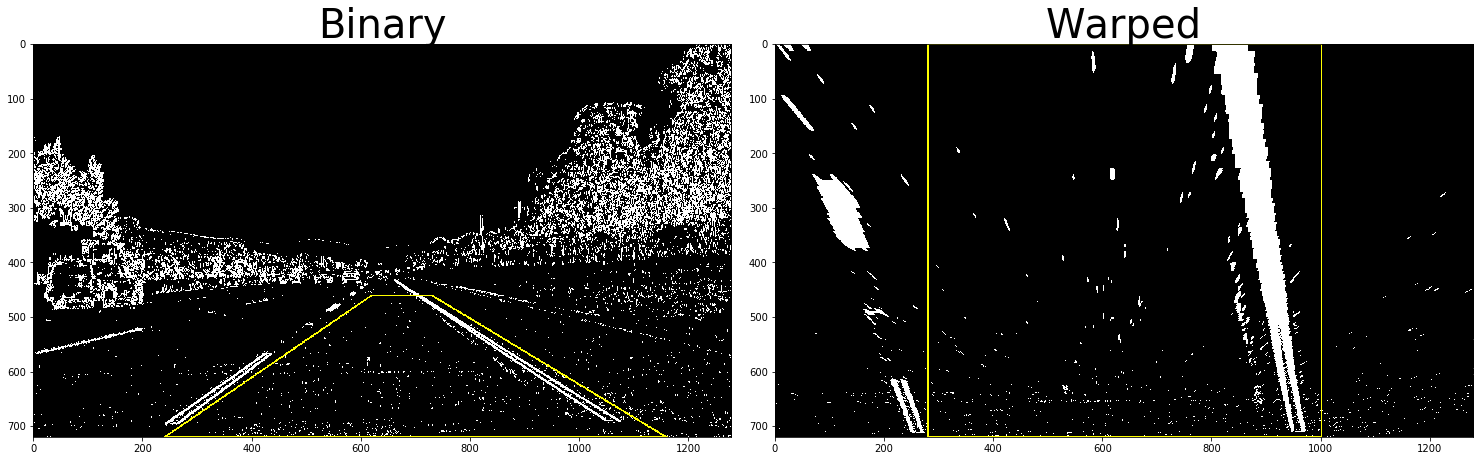

In [11]:
def calc_persp_matr(src_corners, dst_corners):
    src = np.float32(src_corners)
    dst = np.float32(dst_corners)
    m = cv2.getPerspectiveTransform(src, dst)
    m_inv = cv2.getPerspectiveTransform(dst, src)
    return m, m_inv

G_SRC_CORNERS = [[240, G_H], # left bottom
                 [620, 460], # left top
                 [730, 460], # right top
                 [1160, G_H]] # right bottom

#G_SRC_CORNERS = np.array([np.array([LMARGIN, G_H]), # left bottom
#                          np.array([HMARGIN, Y_EDGE]), # left top
#                          np.array([G_W - HMARGIN, Y_EDGE]), # right top
#                          np.array([G_W - LMARGIN, G_H])]) # right bottom
           
G_DST_CORNERS = [[280, G_H],
                 [280, 0],
                 [1000, 0],
                 [1000, G_H]]

G_M, G_M_inv = calc_persp_matr(G_SRC_CORNERS, G_DST_CORNERS)

def perspective_transform(img, M, debug = False):  
    warped = cv2.warpPerspective(img,
                                 M,
                                 (img.shape[1], img.shape[0]),
                                 flags=cv2.INTER_LINEAR)

    return warped

warped = perspective_transform(comb_bin, G_M)

# Plot the result
colored_comb_bin = np.dstack((comb_bin, comb_bin, comb_bin)) * 255
cv2.polylines(colored_comb_bin,
              [np.array(G_SRC_CORNERS,dtype=np.int32).reshape((-1, 1, 2))],
              True,
              (255,255,0),
              thickness = 2)

colored_warped = np.dstack((warped, warped, warped)) * 255
cv2.polylines(colored_warped,
              [np.array(G_DST_CORNERS, dtype=np.int32).reshape((-1, 1, 2))],
              True,
              (255,255,0),
              thickness=2)

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()

ax1.imshow(colored_comb_bin)
ax1.set_title('Binary', fontsize=40)

ax2.imshow(colored_warped)
ax2.set_title('Warped', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Detect lane pixels and fit to find the lane boundary.

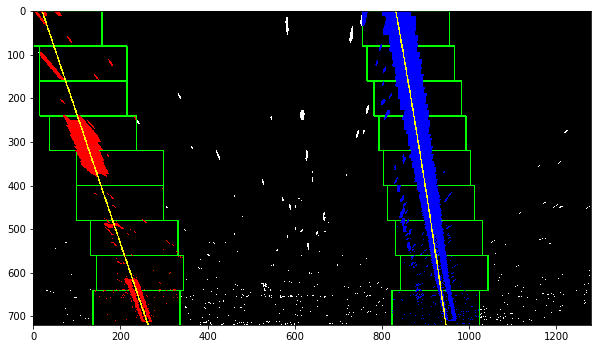

In [12]:
def find_lane_pixels(binary_warped, vis):
    # Visualisation
    out_img = None
    if vis:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 150

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    left_off = 0
    right_off = 0

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ##Find the four below boundaries of the window
        win_xleft_low = leftx_current  - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if vis:
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                          (0, 255, 0), 2) 
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                          (0, 255, 0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_mean = np.int(np.mean(nonzerox[good_left_inds]))
            leftx_current = leftx_mean
            
        if len(good_right_inds) > minpix:
            rightx_mean = np.int(np.mean(nonzerox[good_right_inds]))
            rightx_current = rightx_mean

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, vis):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, vis)

    # Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    if vis:
        # Colorize alne pixels
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        # Draw polynom approximation
        cv2.polylines(out_img,
                      [np.array([left_fitx, ploty], dtype=np.int32).T],
                      False,
                      (255,255,0),
                      thickness=2)
        cv2.polylines(out_img,
                      [np.array([right_fitx, ploty], dtype=np.int32).T],
                      False,
                      (255,255,0),
                      thickness=2)
        

    return ploty, left_fit, right_fit, left_fitx, right_fitx, out_img

py, lf, rf, lfx, rfx, vis = fit_polynomial(warped, True)

# Plots the left and right polynomials on the lane lines
plt.figure(figsize=(10, 10))
plt.imshow(vis)

## Find perspective rectangle with desired top edge width based on linear approximation of lines

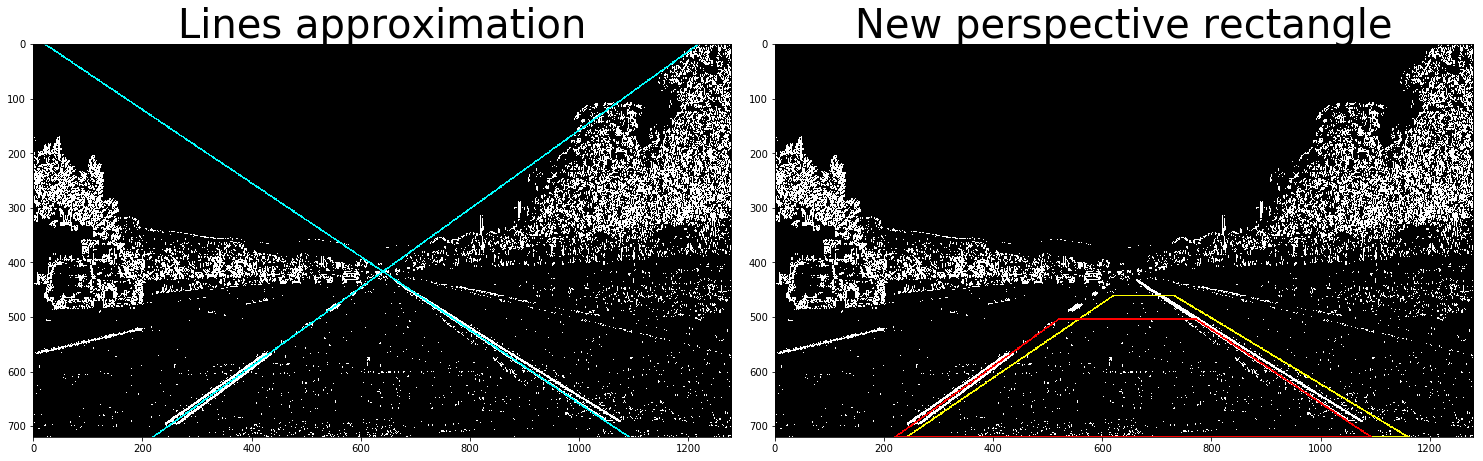

In [13]:
#
# line segment intersection using vectors
# see Computer Graphics by F.S. Hill
#
def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2):
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1

# find k, b for x = ky + b
def fit_line(x_dots, y_dots):
    A = np.vstack([y_dots, np.ones(len(y_dots))]).T     
    k, b = np.linalg.lstsq(A, x_dots)[0]
    return (k, b)

def find_linear_lines(left_dots, right_dots, dbg_img):
    left_x = np.array(left_dots[0].T[0])
    left_y = np.array(left_dots[0].T[1])
    right_x = np.array(right_dots[0].T[0])
    right_y = np.array(right_dots[0].T[1])

    selected_left = ((left_x >=0) & (left_x <= G_W - 1) & (left_y >= 550)).nonzero()[0]
    selected_right = ((right_x >=0) & (right_x <= G_W - 1) & (right_y >= 550)).nonzero()[0]

    (lk, lb) = fit_line(left_x[selected_left], left_y[selected_left])
    (rk, rb) = fit_line(right_x[selected_right], right_y[selected_right])
    
    if dbg_img is not None:        
        dbg_img[left_y[selected_left].astype(int), left_x[selected_left].astype(int)] = [255, 0, 0]
        dbg_img[right_y[selected_right].astype(int), right_x[selected_right].astype(int)] = [0, 0, 255]
        
        y_top, y_bot = 0, 720
        cv2.line(dbg_img, (int(lk * y_bot + lb), y_bot), (int(lk * y_top + lb), y_top), [0, 255, 255], 2)
        cv2.line(dbg_img, (int(rk * y_bot + rb), y_bot), (int(rk * y_top + rb), y_top), [0, 255, 255], 2)
    
    return (lk, lb), (rk, rb)

def find_persp_rectangle(l_line, r_line, rect_top_width, dbg_img = None):    
    # find cross point
    y_top, y_bot = 0, 720
    lk, lb = l_line
    rk, rb = r_line
    lp1 = np.array([lk * y_bot + lb, y_bot])
    lp2 = np.array([lk * y_top + lb, y_top])
    rp1 = np.array([rk * y_bot + rb, y_bot])
    rp2 = np.array([rk * y_top + rb, y_top])
    
    cp = seg_intersect(lp1, lp2, rp1, rp2)
    rect_bot_width = rp1[0] - lp1[0]
    H = y_bot - cp[1]
    L = cp[0] - lp1[0]
    R = rp1[0] - cp[0]

    if (cp[0] >= 0 and cp[0] <= G_W
        and lp1[0] >= 0 and lp1[0] <= G_W
        and rp1[0] >= 0 and rp1[0] <= G_W
        and rect_bot_width > 0 #and L > 0 and R > 0
        and rect_top_width < rect_bot_width):
        
        rect_height =  H * rect_top_width / rect_bot_width
        
        rect = [lp1, np.array([cp[0] - L * rect_top_width / rect_bot_width, cp[1] + rect_height]),
                np.array([cp[0] + R * rect_top_width / rect_bot_width, cp[1] + rect_height]), rp1]
        
        if dbg_img is not None:
            cv2.polylines(dbg_img,
                          [np.array(rect, dtype=np.int32).reshape((-1, 1, 2))],
                          True, (255, 0, 0), thickness = 2)
        
        return rect
           
    return None

py = np.linspace(0, G_H - 1, G_H)
# Convert polynomial dots to original perspective
left_dots = cv2.perspectiveTransform(np.array([np.array([lfx, py], dtype=np.float32).T]), G_M_inv)
right_dots = cv2.perspectiveTransform(np.array([np.array([rfx, py], dtype=np.float32).T]), G_M_inv)

# find linear approximations of lines
pic1 = np.dstack((comb_bin, comb_bin, comb_bin))*255
left_l, right_l = find_linear_lines(left_dots, right_dots, pic1)

pic2 = colored_comb_bin
new_corners = find_persp_rectangle(left_l, right_l, 250, pic2)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(pic1)
ax1.set_title('Lines approximation', fontsize=40)

ax2.imshow(pic2)
ax2.set_title('New perspective rectangle', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Search from prior

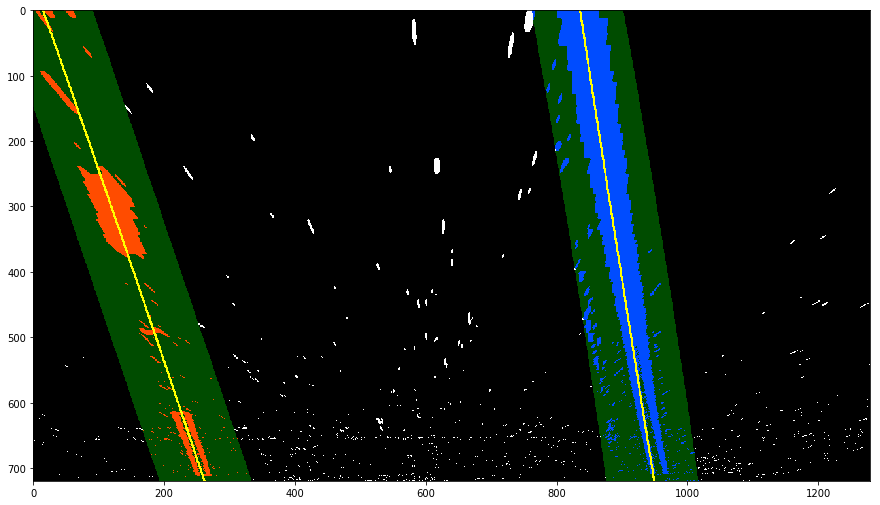

In [14]:
def fit_poly(leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit
    
def find_poly_values(left_fit, right_fit, img_shape):
    # Generate x and y values for plotting
    ploty = np.linspace(0, G_H - 1, G_H)
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 70

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values
    ### within the +/- margin of our polynomial function
    ### Hint: consider the window areas for the similarly named variables
    ### in the previous quiz, but change the windows to our new search area
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    min_found = 100
    new_left_fit, new_right_fit = None, None
    if len(leftx) < min_found or len(rightx) < min_found:
        new_left_fit = left_fit
        new_right_fit = right_fit
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        return ploty, new_left_fit, new_right_fit, None, None, out_img  
    
    # Fit new polynomials
    new_left_fit, new_right_fit = fit_poly(leftx, lefty, rightx, righty)
    
    if (lefty < 360).sum() <= 10:
        A = np.vstack([lefty, np.ones(len(lefty))]).T     
        k, b = np.linalg.lstsq(A, leftx)[0]
        new_left_fit[0] = 0
        new_left_fit[1] = k
        new_left_fit[2] = b
        
    if (righty < 360).sum() <= 10:
        A = np.vstack([righty, np.ones(len(righty))]).T     
        k, b = np.linalg.lstsq(A, rightx)[0]
        new_right_fit[0] = 0
        new_right_fit[1] = k
        new_right_fit[2] = b
    
    left_fitx, right_fitx, ploty = find_poly_values(left_fit, right_fit,
                                                    binary_warped.shape)
    new_left_fitx, new_right_fitx, ploty = find_poly_values(new_left_fit, new_right_fit,
                                                            binary_warped.shape)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.polylines(out_img,
                  [np.array([new_left_fitx, ploty], dtype=np.int32).T],
                  False,
                  (255,255,0),
                  thickness=2)
    cv2.polylines(out_img,
                  [np.array([new_right_fitx, ploty], dtype=np.int32).T],
                  False,
                  (255,255,0),
                  thickness=2)
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
       
    return ploty, new_left_fit, new_right_fit, new_left_fitx, new_right_fitx, result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
py, lf, rf, lfx, rfx, vis2 = search_around_poly(warped, lf, rf)

# View your output
# Plot the polynomial lines onto the image
plt.figure(figsize=(15, 15))
#plt.plot(lfx, py, color='yellow')
#plt.plot(rfx, py, color='yellow')
## End visualization steps ##
plt.imshow(vis2)

## Determine the curvature of the lane and vehicle position with respect to center.

In [15]:
def measure_curvature_real(ploty, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Do the calculation of R_curve (radius of curvature) 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    pos = (img_size[0]/2 - (left_fitx[-1] + right_fitx[-1])/2) * xm_per_pix
    

    return left_curverad, right_curverad, pos

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, pos = measure_curvature_real(py, lfx, rfx)
print(left_curverad, 'm', right_curverad, 'm', pos, 'm')

15443.2046055 m 34475.518966 m 0.179650752676 m


## Warp the detected lane boundaries back onto the original image.

In [16]:
def draw_lane(undist, warped, left_fitx, right_fitx, ploty, M_inv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (G_W, G_H)) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

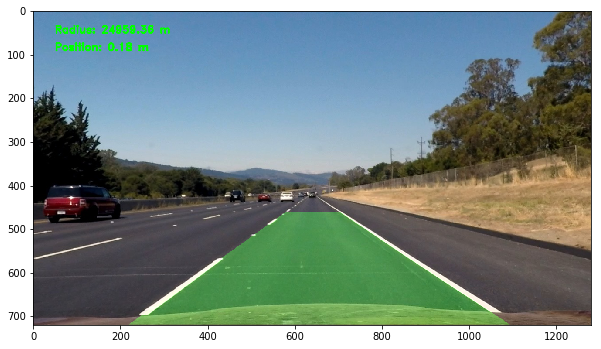

In [17]:
import cv2

def draw_text(img, l_curverad, r_curverad, relative_pos,
              is_found = None, left_fit = None, right_fit = None):
    font = cv2.FONT_HERSHEY_DUPLEX
    curve = ((l_curverad + r_curverad) / 2)
    rad = '%.2f m' % curve if curve is not None else '-'
    pos = '%.2f m' % relative_pos if relative_pos is not None else '-'
    cv2.putText(img, 'Radius: ' + rad, (50, 50), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img, 'Position: ' + pos, (50, 90), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

    return img

result = draw_lane(undist, warped, lfx, rfx, py, G_M_inv)
result = draw_text(result, left_curverad, right_curverad, pos, '-', lf, rf)

plt.figure(figsize=(10, 10))
plt.imshow(result)

## Pipeline

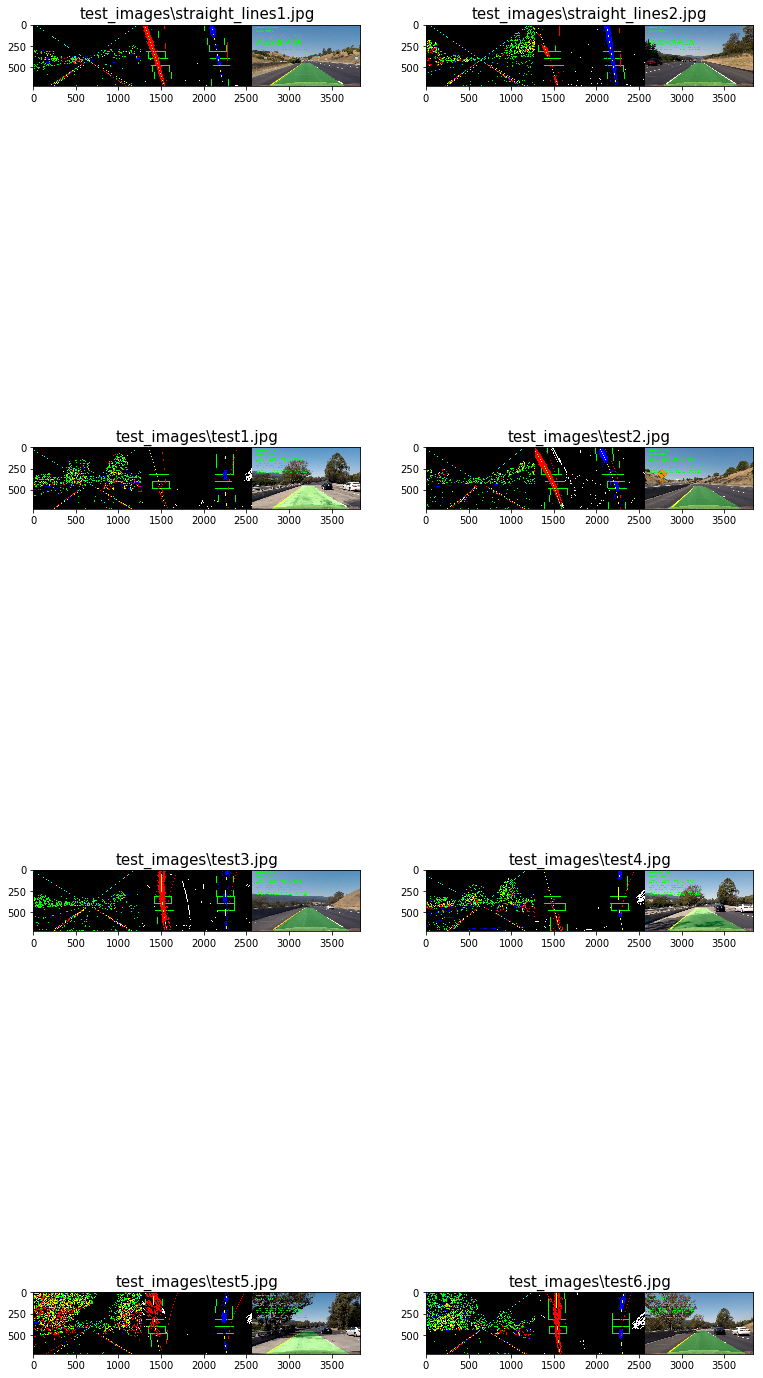

In [18]:
import os
from enum import IntEnum

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.detected = False  # was the line detected in the last iteration?
        self.recent_xfitted = [] # x values of the last n fits of the line
        self.recent_fit = [] # polynomial coefficients of the last n fits of the line
        self.bestx = None #average x values of the fitted line over the last n iterations
        self.best_fit = None #polynomial coefficients averaged over the last n iterations
        self.current_fit = [np.array([False])] #polynomial coefficients for the most recent fit  
        self.rad = None #radius of curvature of the line in some units
        self.diffs = np.array([0,0,0], dtype='float') #difference in fit coefficients between last and new fits
        self.allx = None #x values for detected line pixels
        self.ally = None #y values for detected line pixels
          
class ProcessSeq:
    WARPED_PIXELS_THRES = 110000
    MAX_LOST_FRAMES = 5
    HISTORY_SIZE = 6
    MIN_FRAMES_TO_AVERAGE = 3
    PERSP_RECT_TOP_MIN = 100
    PERSP_RECT_TOP_MAX = 350
    PERSP_RECT_TOP_DEF = 250
    
    def __init__(self, do_average = False, do_debug = False, def_corners = None, def_width = None):
        self.l_lane = Line()
        self.r_lane = Line()
        self.frame = 0
        self.lost_frames = self.MAX_LOST_FRAMES
        self.lane_pos = 0
        self.curv = 0
        self.persp_rect_top = self.PERSP_RECT_TOP_DEF
        if def_width is not None:
            self.persp_rect_top = def_width
        self.history_len = 0
        self.warped_pixels = 0
        self.do_average = do_average
        self.do_debug = do_debug
        lmargin, hmargin, yedge = 220, 515, 500
        self.def_corners = [[lmargin, G_H], # left bottom
                            [hmargin, yedge], # left top
                            [G_W - hmargin, yedge], # right top
                            [G_W - lmargin, G_H]] # right bottom
        if def_corners is not None:
            self.def_corners = def_corners
        self.def_M, self.def_M_inv = calc_persp_matr(self.def_corners, G_DST_CORNERS)

        self.corners = self.def_corners
        self.M, self.M_inv = self.def_M, self.def_M_inv
        
        self.vis_bin = None
    
    def decrease_view_range(self):
        self.persp_rect_top += 10
        if self.persp_rect_top > self.PERSP_RECT_TOP_MAX:
            self.persp_rect_top = self.PERSP_RECT_TOP_MAX
            
    def increase_view_range(self):
        self.persp_rect_top -= 10
        if self.persp_rect_top < self.PERSP_RECT_TOP_MIN:
            self.persp_rect_top = self.PERSP_RECT_TOP_MIN
    
    def reset_view_range(self):
        self.top_persp_rec = self.PERSP_RECT_TOP_DEF
        
    
    def fit_dots(self, left_dots, right_dots):
        leftx = left_dots[0].T[0]
        lefty = left_dots[0].T[1]
        rightx = right_dots[0].T[0]
        righty = right_dots[0].T[1]

        lf, rf = fit_poly(leftx, lefty, rightx, righty)
        lfx, rfx, py = find_poly_values(lf, rf, G_SHAPE)
        
        return lf, rf, lfx, rfx
    
    def refit_lane(self, old_M_inv, new_M, lfx, rfx):
        # Convert back to top view
        py = np.linspace(0, G_H - 1, G_H)
        left_dots = cv2.perspectiveTransform(np.array([np.array([lfx, py], dtype=np.float32).T]), old_M_inv)
        right_dots = cv2.perspectiveTransform(np.array([np.array([rfx, py], dtype=np.float32).T]), old_M_inv)

        # Convert to perspective view with new perspective transform
        left_dots_p = cv2.perspectiveTransform(left_dots, new_M)
        right_dots_p = cv2.perspectiveTransform(right_dots, new_M)

        return self.fit_dots(left_dots_p, right_dots_p)
    
    def update_history(self, old_M_inv, new_M):
        for idx in range(self.history_len):
            lf, rf, lfx, rfx = self.refit_lane(old_M_inv, new_M,
                                               self.l_lane.recent_xfitted[idx], self.r_lane.recent_xfitted[idx])
            self.l_lane.recent_fit[idx], self.r_lane.recent_fit[idx] = lf, rf
            self.l_lane.recent_xfitted[idx], self.r_lane.recent_xfitted[idx] = lfx, rfx
        
    def update_perspective(self, lf, rf, lfx, rfx):
        # Translate lines coordinates to original image
        py = np.linspace(0, G_H - 1, G_H)
        left_dots = cv2.perspectiveTransform(np.array([np.array([lfx, py], dtype=np.float32).T]), self.M_inv)
        right_dots = cv2.perspectiveTransform(np.array([np.array([rfx, py], dtype=np.float32).T]), self.M_inv)
               
        # Find linear lines approximation
        l_line, r_line = find_linear_lines(left_dots, right_dots, self.vis_bin)
        
        # Calculate new perspective matrix 
        corners = find_persp_rectangle(l_line, r_line, self.persp_rect_top)
        
        new_M, new_M_inv = None, None
        if corners:
            new_M, new_M_inv = calc_persp_matr(corners, G_DST_CORNERS)
        
        if corners is not None and new_M is not None:           
            # Update current fit
            left_dots_p = cv2.perspectiveTransform(left_dots, new_M)
            right_dots_p = cv2.perspectiveTransform(right_dots, new_M)
            lf, rf, lfx, rfx = self.fit_dots(left_dots_p, right_dots_p)
            
            if not self.is_good_lane(lf, rf, lfx, rfx):
                return False, lf, rf, lfx, rfx
            
            if self.do_debug:
                cv2.polylines(self.vis_bin,
                              [np.array(corners, dtype=np.int32).reshape((-1, 1, 2))],
                              True,
                              (255,0,0),
                              thickness=2)
                
            # Update history (as previos fits became invalid)
            self.update_history(self.M_inv, new_M)

            # Remember new perspective transform matrix
            self.M = new_M
            self.M_inv = new_M_inv
            self.corners = corners
    
        return True, lf, rf, lfx, rfx 
        
    def is_good_lane(self, left_fit, right_fit, left_fitx, right_fitx):
        if left_fitx is None:
            return False
        
        # If lane cuvature changed too agressively, detection is incorrect
        if self.history_len > 0:
            l_diff = abs(left_fit - self.l_lane.recent_fit[-1])
            r_diff = abs(right_fit - self.r_lane.recent_fit[-1])
            if (l_diff[0] > 5.0e-04 or r_diff[0] > 5.0e-04):
                return False
        
        # If lanes have too different curvature, detection is incorrect
        if (min(abs(left_fit[0]), abs(right_fit[0])) < 2.0e-04
            and abs(left_fit[0] - right_fit[0]) > 6.0e-04):
            return False
        
        if (abs(left_fit[0] - right_fit[0]) > 10.0e-04):
            return False
        
        min_dist = 550
        max_dist = 850
        
        # If distance between lines (in the bootom of image) is too big or too small,
        # lane was detected incorrectly
        dist_bot = abs(left_fitx[G_H-1] - right_fitx[G_H-1])
        if (dist_bot < min_dist or dist_bot > max_dist):
            return False
        
        return True
    
    def is_sharp_turn(self, lf, rf, lfx, rfx, threshold):
        # sharp turn
        if (abs(lf[0]) > threshold or abs(rf[0]) > threshold
            or np.any(lfx < 50)
            or np.any(rfx > 1230)):            
            return True
       
        return False
        
    def is_flat_lane(self, lf, rf):
        if (abs(lf[0]) < 2.0e-04 and abs(rf[0]) < 2.0e-04):           
            return True
        else:
            return False
    
    def reset_history(self):
        del self.l_lane.recent_xfitted[:]
        del self.r_lane.recent_xfitted[:]
        del self.l_lane.recent_fit[:]
        del self.r_lane.recent_fit[:]
        self.history_len = 0
        
    def process_good_lane(self):
        lf, rf = self.l_lane.current_fit, self.r_lane.current_fit
        lfx, rfx = self.l_lane.allx, self.r_lane.allx
        py = self.l_lane.ally
        
        is_good = True
        if self.lost_frames >= self.MAX_LOST_FRAMES:
            self.reset_view_range()
            is_good, lf, rf, lfx, rfx = self.update_perspective(lf, rf, lfx, rfx)
        elif self.is_sharp_turn(lf, rf, lfx, rfx, 3.5e-4):
            self.decrease_view_range()
            is_good, lf, rf, lfx, rfx = self.update_perspective(lf, rf, lfx, rfx)
        elif self.is_flat_lane(lf, rf):
            self.increase_view_range()
            is_good, lf, rf, lfx, rfx = self.update_perspective(lf, rf, lfx, rfx)
        
        self.l_lane.current_fit = lf
        self.r_lane.current_fit = rf
        self.l_lane.allx = lfx
        self.r_lane.allx = rfx
        
        if not is_good:
            return False 

        self.l_lane.detected = True
        self.r_lane.detected = True
        self.lost_frames = 0
        
        self.l_lane.recent_xfitted.append(lfx)
        self.r_lane.recent_xfitted.append(rfx)
        self.l_lane.recent_fit.append(lf)
        self.r_lane.recent_fit.append(rf)
        self.history_len = len(self.l_lane.recent_xfitted)
        if  self.history_len > self.HISTORY_SIZE:
            self.l_lane.recent_xfitted.pop(0)
            self.r_lane.recent_xfitted.pop(0)
            self.l_lane.recent_fit.pop(0)
            self.r_lane.recent_fit.pop(0)
            self.history_len -= 1

        # Calculate the radius of curvature in pixels for both lane lines
        left_curverad, right_curverad, pos = measure_curvature_real(py, lfx, rfx)
        self.l_lane.rad = left_curverad
        self.r_lane.rad = right_curverad
        
        assert(self.history_len == len(self.l_lane.recent_xfitted))        
        return True
        
    def process_bad_lane(self):
        self.l_lane.detected = False
        self.r_lane.detected = False

        if self.history_len > 1:
            self.l_lane.recent_xfitted.pop(0)
            self.r_lane.recent_xfitted.pop(0)
            self.l_lane.recent_fit.pop(0)
            self.r_lane.recent_fit.pop(0)
            self.history_len -= 1    
        elif self.history_len == 0:
            self.l_lane.bestx = None
            self.r_lane.bestx = None            

        self.lost_frames += 1
        if self.lost_frames >= self.MAX_LOST_FRAMES:
            # Reset perspective transform matrix
            self.M, self.M_inv = self.def_M, self.def_M_inv
            self.corners = self.def_corners
            self.l_lane.bestx = None
            self.r_lane.bestx = None
            self.reset_history()
    
    def detect_lane(self, warped_bin_img):
        if self.lost_frames < self.MAX_LOST_FRAMES:
            ploty, lf, rf, lfx, rfx, vis_warped = search_around_poly(warped_bin_img,
                                                                     self.l_lane.recent_fit[-1],
                                                                     self.r_lane.recent_fit[-1])
        else:
            ploty, lf, rf, lfx, rfx, vis_warped = fit_polynomial(warped_bin_img, DBG)
        
        self.l_lane.allx = lfx
        self.r_lane.allx = rfx
        self.l_lane.current_fit = lf
        self.r_lane.current_fit = rf
        self.l_lane.ally = ploty
        self.r_lane.ally = ploty
        
        return vis_warped
    
    def draw_text_info(self, img):
        lf, rf = self.l_lane.current_fit, self.r_lane.current_fit
        
        if ((self.do_average and self.history_len >= self.MIN_FRAMES_TO_AVERAGE)
             or (not self.do_average and self.history_len >= 1)):
            color = (0, 255, 0)
        else:
            color = (255, 0, 0)
            
        txt_size_big = 0.8
        txt_size = 0.5
        txt_reg = 1
        txt_bold = 2
        
        font = cv2.FONT_HERSHEY_DUPLEX
        rad = '%.2f m' % self.curve if self.curve is not None else '-'
        pos = '%.2f m' % self.lane_pos if self.lane_pos is not None else '-'
        cv2.putText(img, 'Radius: ' + rad, (50, 50), font, txt_size_big, color, txt_bold, cv2.LINE_AA)
        cv2.putText(img, 'Position: ' + pos, (50, 90), font, txt_size_big, color, txt_bold, cv2.LINE_AA)
        
        if self.do_debug: 
            if self.l_lane.detected:
                color = (0, 255, 0)
            else:
                color = (255, 0, 0)
            cv2.putText(img, 'Frame: %d' % self.frame ,
                        (50, 140), font, txt_size, (0, 255, 0), txt_reg, cv2.LINE_AA)
            cv2.putText(img, 'Found: ' + str(self.l_lane.detected and self.r_lane.detected),
                        (200, 140), font, txt_size, color, txt_reg, cv2.LINE_AA)
            cv2.putText(img, 'History len: ' + str(self.history_len),
                        (340, 140), font, txt_size, (0, 255, 0), txt_reg, cv2.LINE_AA)
            cv2.putText(img, 'Frames lost: ' + str(self.lost_frames),
                        (480, 140), font, txt_size, (0, 255, 0), txt_reg, cv2.LINE_AA)
            
            cv2.putText(img, 'View range: ' + str(int(self.persp_rect_top)),
                        (50, 160), font, txt_size, (0, 255, 0), txt_reg, cv2.LINE_AA)
            cv2.putText(img, 'Warped pix: ' + str(self.warped_pixels),
                        (200, 160), font, txt_size, (0, 255, 0), txt_reg, cv2.LINE_AA)  

            if self.l_lane.allx is not None:
                cv2.putText(img, 'Width bot: ' + str(abs(self.l_lane.allx[G_H-1] - self.r_lane.allx[G_H-1])),
                            (380, 160), font, txt_size, (0, 255, 0), txt_reg, cv2.LINE_AA)

            cv2.putText(img, 'Left fit: ' + str(lf),
                        (50, 200), font, txt_size, color, txt_reg, cv2.LINE_AA)
            cv2.putText(img, 'Right fit: ' + str(rf),
                        (50, 220), font, txt_size, color, txt_reg, cv2.LINE_AA)
            cv2.putText(img, 'Diff: ' + str(np.subtract(lf, rf)),
                        (50, 240), font, txt_size, color, txt_reg, cv2.LINE_AA)
            
            cv2.putText(img, 'Best left fit: ' + str(self.l_lane.best_fit),
                        (50, 280), font, txt_size, (0, 255, 0), txt_reg, cv2.LINE_AA)
            cv2.putText(img, 'Best right fit: ' + str(self.r_lane.best_fit),
                        (50, 300), font, txt_size, (0, 255, 0), txt_reg, cv2.LINE_AA)
    
        return img
    
    def __call__(self, img, dump_images = False, base = "", output_dir = ""):
        # Undistort
        undist = undistort(img)

        # Make binary
        bin_img, self.vis_bin = make_binary(undist)
        
        # Draw current perspective transform rectangle
        cv2.polylines(self.vis_bin,
                      [np.array(self.corners, dtype=np.int32).reshape((-1, 1, 2))],
                      True,
                      (255,255,0),
                      thickness=2)
        #
        # Perspective transform
        #
        warped_bin_img = perspective_transform(bin_img, self.M)
        self.warped_pixels = warped_bin_img.sum()
        if self.warped_pixels < self.WARPED_PIXELS_THRES:
            #
            # Detect lane
            #
            vis_warped = self.detect_lane(warped_bin_img)
            
            #
            # Process lanes info
            #
            is_good = self.is_good_lane(self.l_lane.current_fit,
                                        self.r_lane.current_fit,
                                        self.l_lane.allx,
                                        self.r_lane.allx)
            if is_good:
                is_good = self.process_good_lane()
            
            if not is_good:
                self.process_bad_lane()
        
            #
            # Draw lane approximations on warped image
            #
            if is_good and self.l_lane.allx is not None:
                cv2.polylines(vis_warped,
                              [np.array([self.l_lane.allx, self.l_lane.ally], dtype=np.int32).T],
                              False, (255, 0, 0), thickness=2)
                cv2.polylines(vis_warped,
                              [np.array([self.r_lane.allx, self.r_lane.ally], dtype=np.int32).T],
                              False, (255, 0, 0), thickness=2)
        else:
            vis_warped = np.dstack((warped_bin_img, warped_bin_img, warped_bin_img)) * 255
            self.process_bad_lane()
            
        
        #
        # Calculate and draw approximations
        #       
        if ((self.do_average and self.history_len >= self.MIN_FRAMES_TO_AVERAGE)
             or (not self.do_average and self.history_len >= 1)):
                       
            self.l_lane.bestx = np.mean(self.l_lane.recent_xfitted, axis=0)
            self.r_lane.bestx = np.mean(self.r_lane.recent_xfitted, axis=0)
            self.l_lane.best_fit = np.mean(self.l_lane.recent_fit, axis=0)
            self.r_lane.best_fit = np.mean(self.r_lane.recent_fit, axis=0)
            
            # Draw lane approximation
            result = draw_lane(undist, warped, self.l_lane.bestx, self.r_lane.bestx, self.l_lane.ally, self.M_inv)
        
            # Calculate the radius of curvature in pixels for both lane lines
            if self.do_average:
                l_curve, r_curve, pos = measure_curvature_real(py, self.l_lane.bestx, self.r_lane.bestx)
            else:
                l_curve, r_curve, pos = measure_curvature_real(py, self.l_lane.allx, self.r_lane.allx)

            self.curve = (l_curve + r_curve) / 2
            self.lane_pos = pos
        else:
            result = undist
            
            self.curve = None
            self.lane_pos = None
        
        result = self.draw_text_info(result)
        self.frame += 1

        if self.do_debug:
            return np.concatenate((self.vis_bin, vis_warped, result), axis=1)
        else:
            return result

# Make a list of images
images = glob.glob('test_images/*.jpg')
images_count = len(images)
fig, ax = plt.subplots(int((images_count + 1) / 2), 2, figsize=(10, 25))

# Define named constants for debug and ndebug modes
DBG = True
NO_DBG = False

# Step through the list
for idx, fname in enumerate(images):
    t_img = cv2.imread(fname)
    t_img = cv2.cvtColor(t_img, cv2.COLOR_BGR2RGB)
    
    # Get base name
    base = os.path.basename(fname)
    base = os.path.splitext(base)[0]
    
    process_img = ProcessSeq(False, DBG, G_SRC_CORNERS, 100)
    result = process_img(t_img, DBG, base, 'output_images')
    
    cv2.imwrite('output_images/res_' + base + '.jpg',
                cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    
    # plot original and final image
    row = int(idx / 2)
    col = idx % 2
    ax[row, col].set_title(fname, fontsize=15)
    ax[row, col].imshow(result)
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [19]:
debug = NO_DBG
debug_suffix = "_dbg" if debug else ""

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(ProcessSeq(True, debug))
%time white_clip.write_videofile('output_videos/project_video_out' + debug_suffix + '.mp4', audio=False)
clip1.close()

[MoviePy] >>>> Building video output_videos/project_video_out.mp4
[MoviePy] Writing video output_videos/project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:07<00:00,  2.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_out.mp4 

Wall time: 7min 8s


In [20]:
debug = NO_DBG
debug_suffix = "_dbg" if debug else ""

clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(ProcessSeq(True, debug))
%time white_clip.write_videofile('output_videos/challenge_video_out' + debug_suffix + '.mp4', audio=False)
clip1.close()

[MoviePy] >>>> Building video output_videos/challenge_video_out.mp4
[MoviePy] Writing video output_videos/challenge_video_out.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:37<00:00,  3.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video_out.mp4 

Wall time: 2min 38s


In [21]:
debug = NO_DBG
debug_suffix = "_dbg" if debug else ""

clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(ProcessSeq(True, debug))
%time white_clip.write_videofile('output_videos/harder_challenge_video_out' + debug_suffix + '.mp4', audio=False)
clip1.close()

[MoviePy] >>>> Building video output_videos/harder_challenge_video_out.mp4
[MoviePy] Writing video output_videos/harder_challenge_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [06:37<00:00,  3.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video_out.mp4 

Wall time: 6min 39s
